## Banking Customer Segmentation using K-Means Algorithm

#### About Project: 
Customer segmentation is the process of dividing a customers based on common characteristics such as demographics or behavior. In this project, I performed customer segmentation on a dataset containing customer demographics and transactions data from an Indian bank. The dataset is sourced from Kaggle. 

#### Dataset: 
This dataset consists of 1 Million+ transactions by over 800K customers for a bank in India. The data includes information such as customer age (DOB), location, gender, account balance at the time of the transaction, transaction details, transaction amount, etc.

#### Objective
Perform customer segmentation using K-Means algorithm and identify clusters of customers. This allows the bank to better understand their customers spending behaviours and hence tailor their offerings according to customers' preferences, ultimately leading to better services boosting the business.

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import sklearn
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

- Data import

In [2]:
#import dataset
df1 = pd.read_csv('CustomerSeg/dataset/bank_transactions.csv')
df1 = df1.sample(n=100000,random_state = 42)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 892845 to 804143
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   TransactionID            100000 non-null  object 
 1   CustomerID               100000 non-null  object 
 2   CustomerDOB              99671 non-null   object 
 3   CustGender               99899 non-null   object 
 4   CustLocation             99992 non-null   object 
 5   CustAccountBalance       99783 non-null   float64
 6   TransactionDate          100000 non-null  object 
 7   TransactionTime          100000 non-null  int64  
 8   TransactionAmount (INR)  100000 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 7.6+ MB


In [3]:
df1.head(5)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
892845,T892846,C5725279,8/9/84,M,JASPUR,84447.82,7/9/16,183210,11858.0
444994,T444995,C4588538,2/1/94,M,GURGAON,12549.49,16/8/16,161300,250.0
614896,T614897,C2416476,14/11/90,M,NEW DELHI,33607.65,26/8/16,102007,3360.0
457036,T457037,C5940151,15/9/90,M,HYDERABAD,38238.86,21/8/16,110438,250.0
997441,T997442,C5922989,27/11/88,M,PURBO MEDINIPUR,9506.85,14/9/16,90810,33.0


#### Data Exploration:

In [4]:
df1.shape

(100000, 9)

In [5]:
#Checking data types
df1.dtypes

TransactionID               object
CustomerID                  object
CustomerDOB                 object
CustGender                  object
CustLocation                object
CustAccountBalance         float64
TransactionDate             object
TransactionTime              int64
TransactionAmount (INR)    float64
dtype: object

In [6]:
#Convert datatype to datetime
df1['TransactionDate'] = pd.to_datetime(df1['TransactionDate'])
df1['CustomerDOB'] = pd.to_datetime(df1['CustomerDOB'])

TransactionID                      object
CustomerID                         object
CustomerDOB                datetime64[ns]
CustGender                         object
CustLocation                       object
CustAccountBalance                float64
TransactionDate            datetime64[ns]
TransactionTime                     int64
TransactionAmount (INR)           float64
dtype: object

In [7]:
#Checking for missing values
df1.isnull().sum()

TransactionID                0
CustomerID                   0
CustomerDOB                329
CustGender                 101
CustLocation                 8
CustAccountBalance         217
TransactionDate              0
TransactionTime              0
TransactionAmount (INR)      0
dtype: int64

- Columns with MISSING values: 'CustomerDOB', 'CustGender', 'CustLocation', 'CustAccountBalance'

In [8]:
pd.options.display.float_format = '{:.2f}'.format

In [9]:
df1.describe()

,CustAccountBalance,TransactionTime,TransactionAmount (INR)
count,99783.00,100000.00,100000.00
mean,114767.94,157098.48,1606.44
std,877576.74,51370.51,6345.22
min,0.00,1.00,0.00
25%,4732.16,124046.75,165.17
50%,16816.54,164322.50,462.00
75%,57397.30,200054.25,1200.00
max,115035495.10,235958.00,600008.32


In [10]:
df1['CustGender'].value_counts()

M    73107
F    26792
Name: CustGender, dtype: int64

In [11]:
df1['CustLocation'].unique

<bound method Series.unique of 892845             JASPUR
444994            GURGAON
614896          NEW DELHI
457036          HYDERABAD
997441    PURBO MEDINIPUR
               ...       
150569          BANGALORE
713276              NOIDA
566769           AGARTALA
21044           AHMEDABAD
804143            VELLORE
Name: CustLocation, Length: 100000, dtype: object>

- Handling Missing values:

In [12]:
df1.dropna(inplace=True)
df1.isnull().sum()

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64

In [13]:
df1.duplicated().sum()

0

In [14]:
df1['CustomerDOB'].value_counts()

1800-01-01    5385
1989-01-01      81
1991-01-01      72
1987-01-01      68
1991-06-08      62
              ... 
2052-12-14       1
1977-12-22       1
2040-10-02       1
2071-02-08       1
2066-11-24       1
Name: CustomerDOB, Length: 12511, dtype: int64

- Dropping Outlier dates: 1800, years > 2023

In [15]:
df1 = df1.drop(df1[df1['CustomerDOB'] == '1/1/1800'].index,axis = 0)

In [16]:
df1['CustomerDOB'].dt.year.value_counts()

1990    6864
1991    6713
1989    6520
1992    6464
1988    6083
        ... 
2008       1
2006       1
2028       1
2013       1
2011       1
Name: CustomerDOB, Length: 92, dtype: int64

In [17]:
df1['CustomerDOB'].dt.year.unique()

array([1984, 1994, 1990, 1988, 1989, 1987, 1992, 1993, 1977, 1982, 1976,
       1991, 1998, 1986, 1979, 2072, 1981, 1985, 1997, 2050, 1996, 1983,
       2064, 1980, 2065, 1978, 2059, 2068, 2070, 1995, 1975, 1973, 2071,
       1974, 2066, 2062, 2063, 2051, 2003, 2067, 2061, 2053, 2037, 2049,
       2060, 2042, 2058, 2069, 2052, 2043, 2046, 2054, 2055, 2040, 2044,
       2038, 2057, 2047, 2041, 2056, 2001, 1999, 2048, 2045, 2012, 2039,
       2036, 2015, 2029, 2026, 2014, 2000, 2002, 2021, 2033, 2034, 2008,
       2030, 2032, 2031, 2004, 2035, 2024, 2027, 2007, 2009, 2006, 2019,
       2005, 2028, 2013, 2011], dtype=int64)

In [18]:
df1.loc[df1.CustomerDOB.dt.year >= 2023, 'CustomerDOB'] = df1.loc[df1.CustomerDOB.dt.year >= 2023, 'CustomerDOB'] - pd.DateOffset(years=100)


- Calculating the CustomerAge column

In [19]:
df1['CustomerAge'] = ((pd.to_datetime('today') - df1['CustomerDOB']) / np.timedelta64(1, 'Y')).round(0)

In [20]:
df1['CustomerAge'].describe()

count   93965.00
mean       38.58
std         8.83
min         3.00
25%        33.00
50%        36.00
75%        42.00
max       100.00
Name: CustomerAge, dtype: float64

In [21]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93965 entries, 892845 to 804143
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   TransactionID            93965 non-null  object        
 1   CustomerID               93965 non-null  object        
 2   CustomerDOB              93965 non-null  datetime64[ns]
 3   CustGender               93965 non-null  object        
 4   CustLocation             93965 non-null  object        
 5   CustAccountBalance       93965 non-null  float64       
 6   TransactionDate          93965 non-null  datetime64[ns]
 7   TransactionTime          93965 non-null  int64         
 8   TransactionAmount (INR)  93965 non-null  float64       
 9   CustomerAge              93965 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(1), object(4)
memory usage: 7.9+ MB


Exploratory Analysis:

In [22]:
df = df1.copy()

Understanding Customer Demographics:

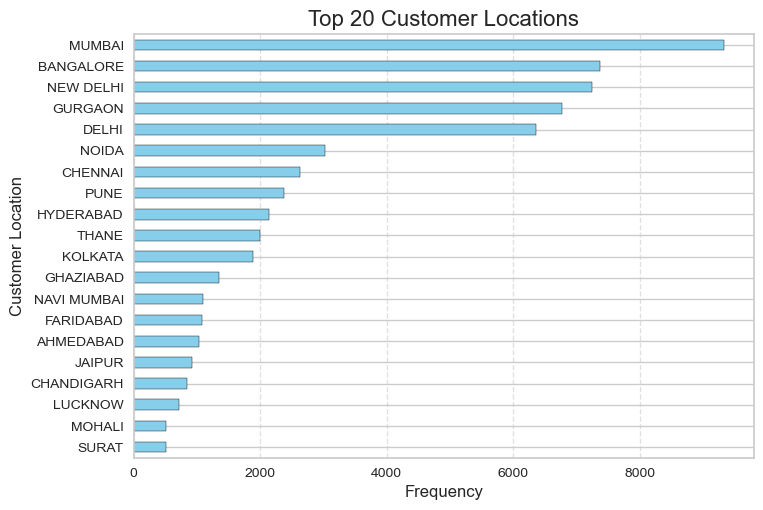

In [23]:
df1['CustLocation'].value_counts()[:20].sort_values(ascending=True).plot(kind='barh', color='skyblue', edgecolor='black')

plt.title('Top 20 Customer Locations', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Customer Location', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.show()

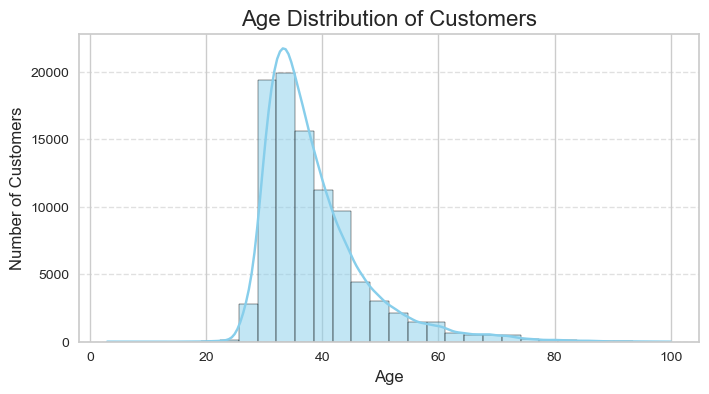

In [24]:
# Assuming df1 is your DataFrame
plt.figure(figsize=(8, 4))
sns.histplot(df1['CustomerAge'], bins=30, kde=True, color='skyblue')

# Customize the plot
plt.title('Age Distribution of Customers', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Adjust font size for tick labels on both axes
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.show()

Most customers are arounf the age 30-40

- Customer Account and Transaction Analysis:

In [25]:
df.columns

Index(['TransactionID', 'CustomerID', 'CustomerDOB', 'CustGender',
       'CustLocation', 'CustAccountBalance', 'TransactionDate',
       'TransactionTime', 'TransactionAmount (INR)', 'CustomerAge'],
      dtype='object')

In [26]:
df.CustAccountBalance.describe()

count       93965.00
mean       106378.11
std        879008.60
min             0.00
25%          4602.13
50%         16041.66
75%         53580.00
max     115035495.10
Name: CustAccountBalance, dtype: float64

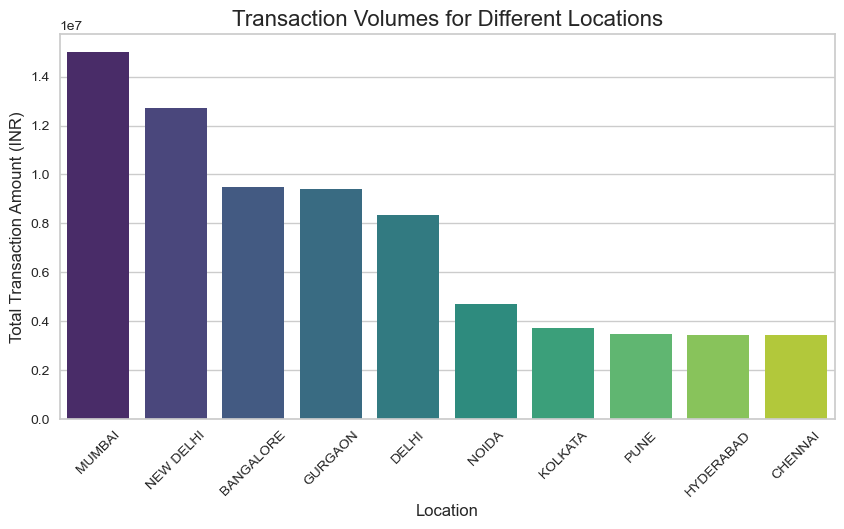

In [27]:
location_transaction_volumes = df.groupby('CustLocation')['TransactionAmount (INR)'].sum().nlargest(10).sort_values(ascending=False)

# Visualize the transaction volumes for each location using a bar plot
plt.figure(figsize=(10, 5))  # Reduced figsize
sns.barplot(x=location_transaction_volumes.index, y=location_transaction_volumes.values, palette='viridis')  
plt.title('Transaction Volumes for Different Locations', fontsize=16)
plt.xlabel('Location', fontsize=12)
plt.ylabel('Total Transaction Amount (INR)', fontsize=12)
plt.xticks(rotation=45, fontsize=10)  # Adjusted rotation and font size for x-axis labels

# Show the plot
plt.show()

__Handling Outliers in the 'CustAccountBalance' and 'TransactionAmount (INR)' amount columns__

In [28]:
# Outlier Handling using IQR method
def handle_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[column] = data[column].apply(lambda x: upper_bound if x > upper_bound else lower_bound if x < lower_bound else x)
    return data

In [29]:
# Handling outliers for CustAccountBalance and TransactionAmount (INR) columns
df = handle_outliers_iqr(df, 'CustAccountBalance')
df = handle_outliers_iqr(df, 'TransactionAmount (INR)')

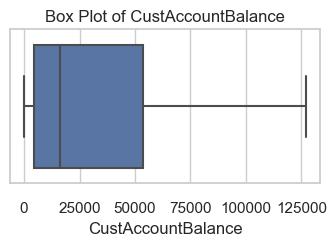

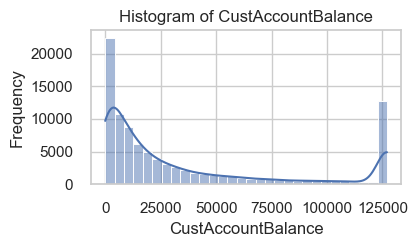

In [30]:
sns.set(style="whitegrid")
plt.figure(figsize=(4, 2))

# Box plot to visualize the distribution and identify outliers
sns.boxplot(x=df['CustAccountBalance'])

plt.title('Box Plot of CustAccountBalance')
plt.show()

# Histogram to see the distribution in more detail
plt.figure(figsize=(4, 2))
sns.histplot(df['CustAccountBalance'], bins=30, kde=True)

plt.title('Histogram of CustAccountBalance')
plt.xlabel('CustAccountBalance')
plt.ylabel('Frequency')
plt.show()


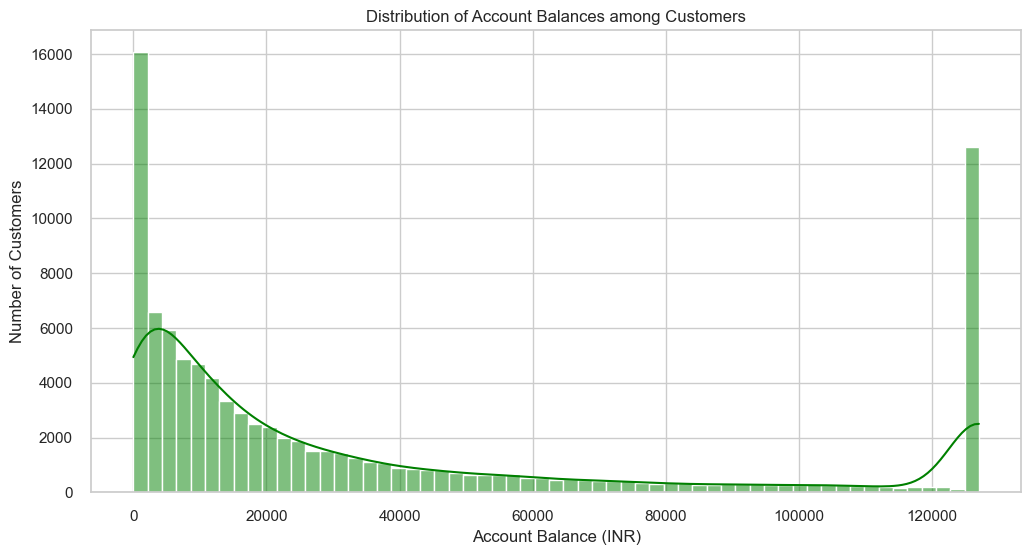

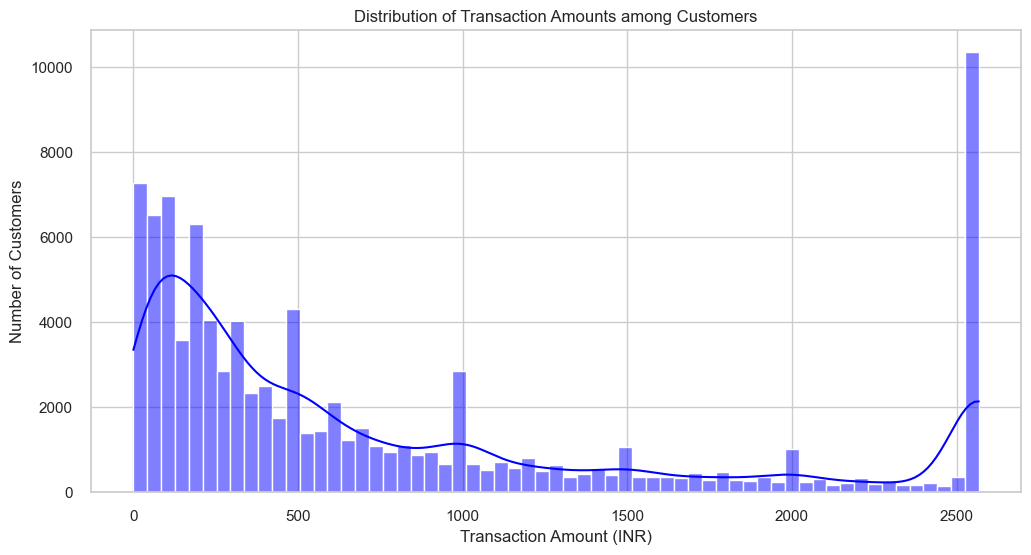

In [31]:
# Distribution of account balances (CustAccountBalance) among customers
plt.figure(figsize=(12, 6))
sns.histplot(df['CustAccountBalance'], kde=True, color='green')
plt.title('Distribution of Custome Account Balance')
plt.xlabel('Account Balance (INR)')
plt.ylabel('Number of Customers')
plt.show()

# Distribution of transaction amounts (TransactionAmount (INR)) among customers
plt.figure(figsize=(12, 6))
sns.histplot(df['TransactionAmount (INR)'], kde=True, color='blue')
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount (INR)')
plt.ylabel('Number of Customers')
plt.show()



Is there any relationship between 'CustAccountBalance' and 'TransactionAmount'?

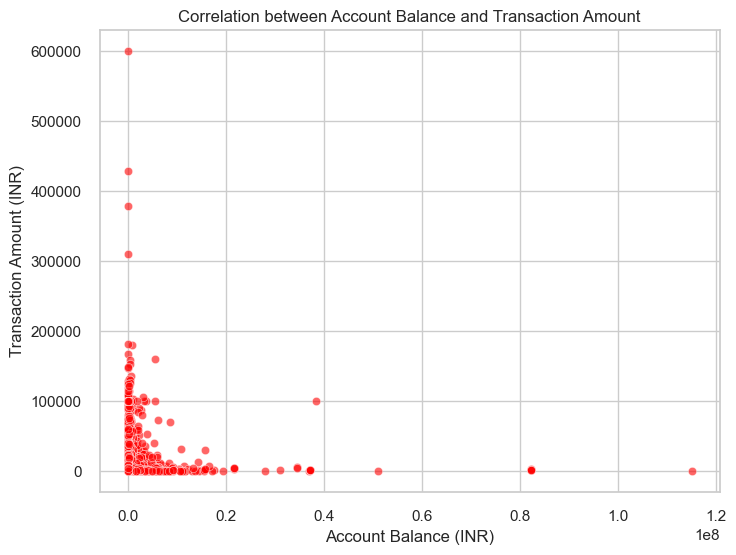

In [32]:
# Correlation between customer account balance and transaction amount
plt.figure(figsize=(8, 6))
sns.scatterplot(x='CustAccountBalance', y='TransactionAmount (INR)', data=df1, color='red', alpha=0.6)
plt.title('Correlation between Account Balance and Transaction Amount')
plt.xlabel('Account Balance (INR)')
plt.ylabel('Transaction Amount (INR)')
plt.show()

There is no linear correlation between these two variables.

In [33]:
df[["TransactionAmount (INR)", "CustAccountBalance"]].describe()

,TransactionAmount (INR),CustAccountBalance
count,93965.00,93965.00
mean,784.08,36766.43
std,833.39,43693.27
min,0.00,0.00
25%,155.00,4602.13
50%,436.05,16041.66
75%,1120.00,53580.00
max,2567.50,127046.81


### Model Building

#### Data Preprocessing

In [34]:
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),CustomerAge
892845,T892846,C5725279,1984-08-09,M,JASPUR,84447.82,2016-07-09,183210,2567.50,39.00
444994,T444995,C4588538,1994-02-01,M,GURGAON,12549.49,2016-08-16,161300,250.00,30.00
614896,T614897,C2416476,1990-11-14,M,NEW DELHI,33607.65,2016-08-26,102007,2567.50,33.00
457036,T457037,C5940151,1990-09-15,M,HYDERABAD,38238.86,2016-08-21,110438,250.00,33.00
997441,T997442,C5922989,1988-11-27,M,PURBO MEDINIPUR,9506.85,2016-09-14,90810,33.00,35.00


Apply label encoder for 'CustGender' and 'CustLocation' categorical variables

In [35]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
  
df['CustGender']= le.fit_transform(df['CustGender'])
df['CustLocation']= le.fit_transform(df['CustLocation'])
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),CustomerAge
892845,T892846,C5725279,1984-08-09,1,1524,84447.82,2016-07-09,183210,2567.50,39.00
444994,T444995,C4588538,1994-02-01,1,1325,12549.49,2016-08-16,161300,250.00,30.00
614896,T614897,C2416476,1990-11-14,1,2437,33607.65,2016-08-26,102007,2567.50,33.00
457036,T457037,C5940151,1990-09-15,1,1443,38238.86,2016-08-21,110438,250.00,33.00
997441,T997442,C5922989,1988-11-27,1,2801,9506.85,2016-09-14,90810,33.00,35.00


In [36]:
#dropping columns that are not in out interest

df = df.drop(['TransactionID','CustomerID','CustomerDOB','TransactionDate','TransactionTime'],axis=1)


In [37]:
df.describe()

,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge
count,93965.00,93965.00,93965.00,93965.00,93965.00
mean,0.72,1740.63,36766.43,784.08,38.58
std,0.45,988.85,43693.27,833.39,8.83
min,0.00,0.00,0.00,0.00,3.00
25%,0.00,895.00,4602.13,155.00,33.00
50%,1.00,1689.00,16041.66,436.05,36.00
75%,1.00,2437.00,53580.00,1120.00,42.00
max,1.00,3913.00,127046.81,2567.50,100.00


In [38]:
df[df['TransactionAmount (INR)'] == 0].count()

CustGender                 67
CustLocation               67
CustAccountBalance         67
TransactionAmount (INR)    67
CustomerAge                67
dtype: int64

In [39]:
#dropping columns with no transcation amount
df= df.drop(df[df['TransactionAmount (INR)'] == 0].index,axis = 0)

In [40]:
df.describe()

,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge
count,93898.00,93898.00,93898.00,93898.00,93898.00
mean,0.72,1740.72,36759.26,784.64,38.58
std,0.45,988.90,43690.64,833.42,8.83
min,0.00,0.00,0.00,0.01,3.00
25%,0.00,895.00,4602.61,155.00,33.00
50%,1.00,1690.00,16032.51,438.00,36.00
75%,1.00,2437.00,53550.27,1120.00,42.00
max,1.00,3913.00,127046.81,2567.50,100.00


In [41]:

#Scaling the column values of interest 

columns_names=['CustGender','CustLocation','CustAccountBalance','TransactionAmount (INR)','CustomerAge']
scale = StandardScaler()
df_scaled = scale.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled,columns=columns_names)
df_scaled.head()

,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge
0,0.62,-0.22,1.09,2.14,0.05
1,0.62,-0.42,-0.55,-0.64,-0.97
2,0.62,0.70,-0.07,2.14,-0.63
3,0.62,-0.30,0.03,-0.64,-0.63
4,0.62,1.07,-0.62,-0.90,-0.41


In [42]:
df_scaled['TransactionAmount (INR)'].max()

2.1392089359900988

### Modeling using K-Means

In [43]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [44]:
X = df_scaled[['CustomerAge', 'TransactionAmount (INR)']].values

Elbow method to determine K

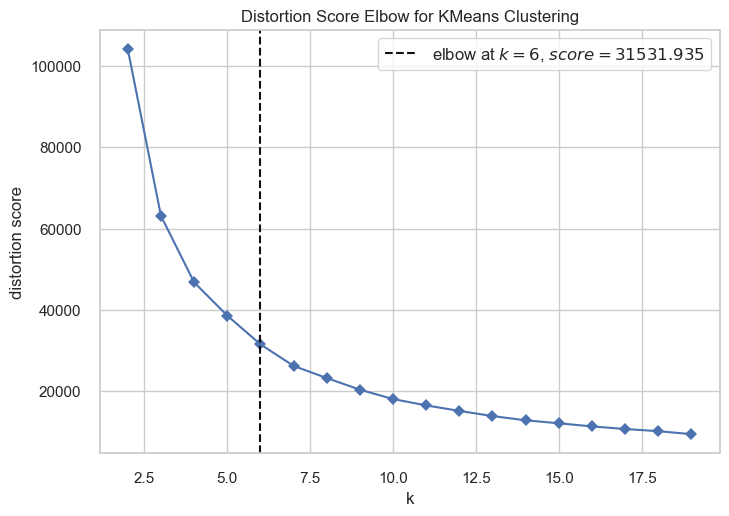

In [45]:
# Function to perform KMeans clustering and plot the elbow method
def perform_elbow_method(X, k_range, title):
    model = KMeans(init='k-means++', random_state=42)
    visualizer = KElbowVisualizer(model, k=k_range, timings=False)
    visualizer.fit(X)
    plt.title(title)
    visualizer.show()

with warnings.catch_warnings():
# ignore all caught warnings
    warnings.filterwarnings("ignore")
    
perform_elbow_method(X, k_range=(2, 20), title='Elbow Method for Customer Age Clustering')

K= 6 provides the best fit for the optimal number of clusters using Elbow method.

- Perform modeling and extract cluster centriods and lables

In [46]:
def perform_kmeans_clustering(X, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    cluster_centers = kmeans.cluster_centers_
    return cluster_labels, cluster_centers

x_cluster_labels, x_cluster_centers = perform_kmeans_clustering(X, num_clusters=6)

In [47]:
print("x_cluster_labels",x_cluster_labels)
print("x_cluster_centers",x_cluster_centers)

x_cluster_labels [3 4 3 ... 5 4 3]
x_cluster_centers [[-0.31434223  0.40592911]
 [ 2.87773563 -0.19840308]
 [ 1.75741942  1.81122249]
 [-0.18529756  1.93050481]
 [-0.61149139 -0.67097107]
 [ 0.63476914 -0.43444255]]


In [48]:
# Add cluster labels to the DataFrame
df_scaled['cluster_age'] = x_cluster_labels

# Add centroids to the DataFrame
df_scaled['cen_xx'] = df_scaled.cluster_age.map({i: x_cluster_centers[i][0] for i in range(6)})
df_scaled['cen_xy'] = df_scaled.cluster_age.map({i: x_cluster_centers[i][1] for i in range(6)})

df_scaled.head()

,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,cluster_age,cen_xx,cen_xy
0,0.62,-0.22,1.09,2.14,0.05,3,-0.19,1.93
1,0.62,-0.42,-0.55,-0.64,-0.97,4,-0.61,-0.67
2,0.62,0.70,-0.07,2.14,-0.63,3,-0.19,1.93
3,0.62,-0.30,0.03,-0.64,-0.63,4,-0.61,-0.67
4,0.62,1.07,-0.62,-0.90,-0.41,4,-0.61,-0.67


In [49]:
# Define colors for each cluster
colors_X = ['red', 'yellow', 'grey', 'green', 'blue', 'orange']

# Add cluster colors to the DataFrame
df_scaled['color_age_km'] = df_scaled.cluster_age.map({i: colors_X[i] for i in range(6)})
df_scaled.head()

,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,cluster_age,cen_xx,cen_xy,color_age_km
0,0.62,-0.22,1.09,2.14,0.05,3,-0.19,1.93,green
1,0.62,-0.42,-0.55,-0.64,-0.97,4,-0.61,-0.67,blue
2,0.62,0.70,-0.07,2.14,-0.63,3,-0.19,1.93,green
3,0.62,-0.30,0.03,-0.64,-0.63,4,-0.61,-0.67,blue
4,0.62,1.07,-0.62,-0.90,-0.41,4,-0.61,-0.67,blue


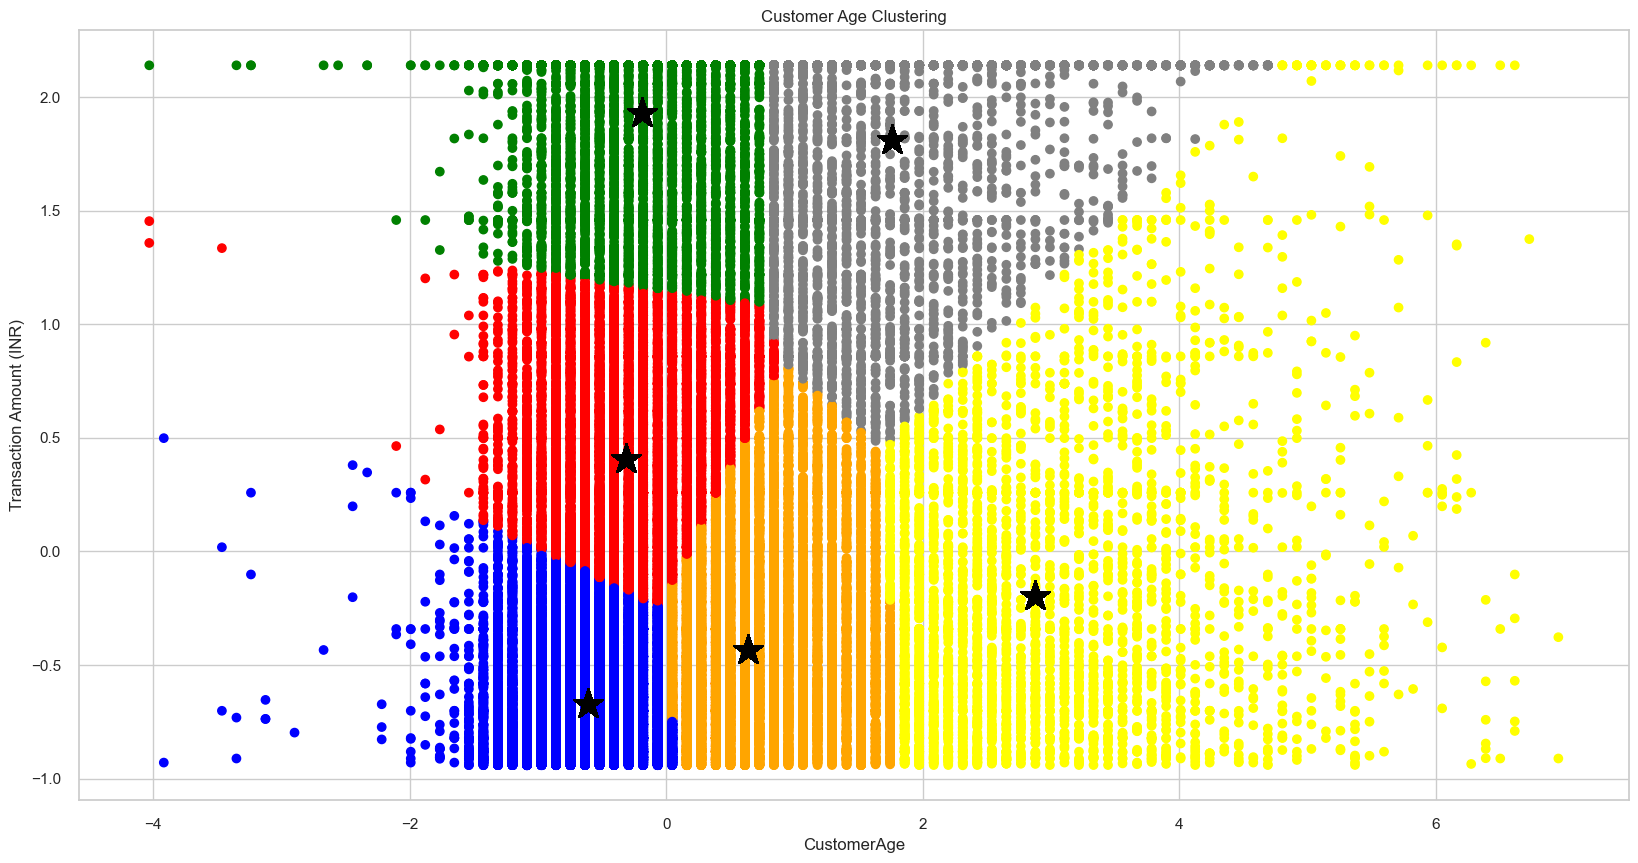

In [50]:
# Plot the scatter plot with cluster colors and centroids for 'Customer age' and 'TransactionAmount (INR)'
plt.figure(figsize=(20, 10))
plt.scatter(df_scaled['CustomerAge'], df_scaled['TransactionAmount (INR)'], c=df_scaled.color_age_km)
plt.scatter(df_scaled['cen_xx'], df_scaled['cen_xy'], marker='*', s=500, c='black')
plt.xlabel('CustomerAge')
plt.ylabel('Transaction Amount (INR)')
plt.title('Customer Age Clustering')
plt.show()

In [51]:
df_scaled['cluster_age'].value_counts()

4    41698
5    18507
0    13336
3    11440
2     5062
1     3855
Name: cluster_age, dtype: int64

#### Model Evaluation:

In [52]:
from sklearn.metrics import silhouette_score

# Silhouette Score for cluster_age
silhouette_score_age = silhouette_score(df_scaled[['TransactionAmount (INR)', 'CustomerAge']], df_scaled['cluster_age'])
print("Silhouette Score for cluster_age:", silhouette_score_age)

Silhouette Score for cluster_age: 0.44671562513433044


In [53]:
age_cluster_avg = df_scaled.groupby('CustomerAge').mean().reset_index()

print(age_cluster_avg[['CustLocation','CustAccountBalance','TransactionAmount (INR)','CustomerAge']])

    CustLocation  CustAccountBalance  TransactionAmount (INR)  CustomerAge
0           0.70                2.07                     1.65        -4.03
1          -0.86               -0.22                    -0.22        -3.92
2          -1.25               -0.14                     0.22        -3.46
3          -0.05                0.17                     0.17        -3.35
4           0.10                1.10                     1.11        -3.24
..           ...                 ...                      ...          ...
87          0.69               -0.43                    -0.46         6.39
88         -1.08                1.94                     0.30         6.50
89          1.21                0.95                    -0.06         6.61
90          1.58                2.07                     1.37         6.73
91         -0.30                2.07                    -0.64         6.95

[92 rows x 4 columns]


In [54]:
df['Age_Cluster'] = x_cluster_labels
df.head()

,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,Age_Cluster
892845,1,1524,84447.82,2567.50,39.00,3
444994,1,1325,12549.49,250.00,30.00,4
614896,1,2437,33607.65,2567.50,33.00,3
457036,1,1443,38238.86,250.00,33.00,4
997441,1,2801,9506.85,33.00,35.00,4


In [55]:
(df['Age_Cluster']==0).value_counts()

False    80562
True     13336
Name: Age_Cluster, dtype: int64

Creating age groups for further analysis

In [56]:
age_under18 =  df.CustomerAge[df.CustomerAge < 18]
age_18_25 =  df.CustomerAge[(df.CustomerAge >= 18) & (df.CustomerAge <=25)] 
age_26_35 =  df.CustomerAge[(df.CustomerAge >= 26) & (df.CustomerAge <=35)] 
age_36_45 =  df.CustomerAge[(df.CustomerAge >= 36) & (df.CustomerAge <=45)] 
age_46_55 =  df.CustomerAge[(df.CustomerAge >= 46) & (df.CustomerAge <=55)] 
age_56_65 =  df.CustomerAge[(df.CustomerAge >= 56) & (df.CustomerAge <=65)] 
age_above66 =  df.CustomerAge[df.CustomerAge >= 66]


agex = ['under18', '18-25', '26-35', '36-45','46-55','56-65', '66+']

agey = [len(age_under18.values), len(age_18_25.values),len(age_26_35.values),len(age_36_45.values),len(age_46_55.values),len(age_56_65.values),len(age_above66.values)]

In [57]:
conditions = [
         (df['CustomerAge'] < 18),
        (df['CustomerAge'] >= 18) & (df['CustomerAge'] <=25),
        (df['CustomerAge'] >= 26) & (df.CustomerAge <=35), 
        (df['CustomerAge']  >= 36) & (df.CustomerAge <=45),
        (df['CustomerAge']  >= 46) & (df.CustomerAge <=55),
        (df['CustomerAge']  >= 56) & (df.CustomerAge <=65),
        (df['CustomerAge']  >= 66)
]

df['AgeGroup'] = np.select(conditions, agex)

In [58]:
df.head()

,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,Age_Cluster,AgeGroup
892845,1,1524,84447.82,2567.50,39.00,3,36-45
444994,1,1325,12549.49,250.00,30.00,4,26-35
614896,1,2437,33607.65,2567.50,33.00,3,26-35
457036,1,1443,38238.86,250.00,33.00,4,26-35
997441,1,2801,9506.85,33.00,35.00,4,26-35


In [59]:
df.groupby('Age_Cluster', as_index=False)['CustomerAge'].mean()

,Age_Cluster,CustomerAge
0,0,35.84
1,1,64.02
2,2,54.11
3,3,36.94
4,4,33.18
5,5,44.20


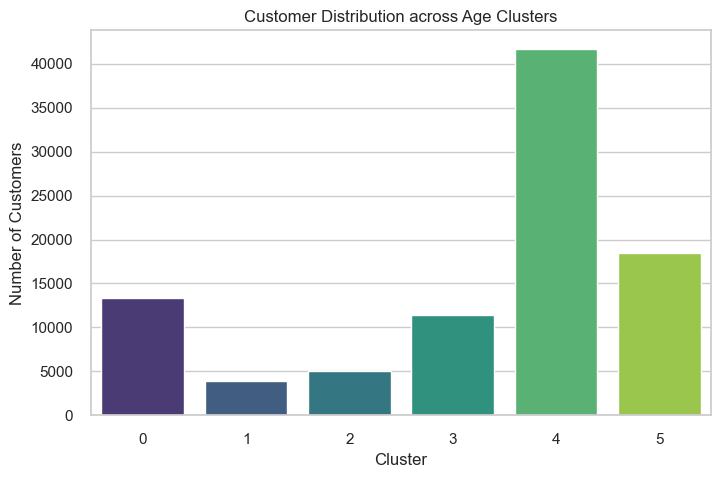

In [60]:
# Count the number of customers in each cluster
age_cluster_counts = df_scaled['cluster_age'].value_counts().reset_index()
age_cluster_counts.columns = ['Cluster', 'Count']
plt.figure(figsize=(8, 5))
sns.barplot(x='Cluster', y='Count', data=age_cluster_counts, palette='viridis')
plt.title('Customer Distribution across Age Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()


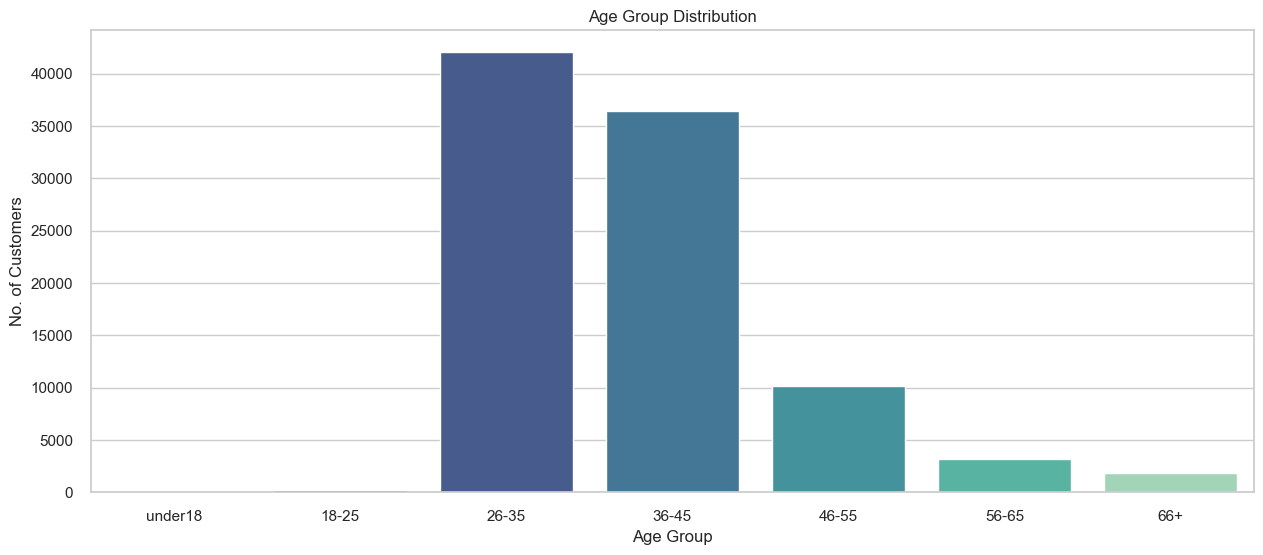

In [61]:
plt.figure(figsize=(15,6))
sns.barplot(x = agex, y = agey, palette = 'mako')
plt.title('Age Group Distribution')
plt.xlabel('Age Group')
plt.ylabel('No. of Customers')
plt.show()

__Plotting heatmap to visualize average Amount and age grouped by clusters__

<Axes: ylabel='Age_Cluster'>

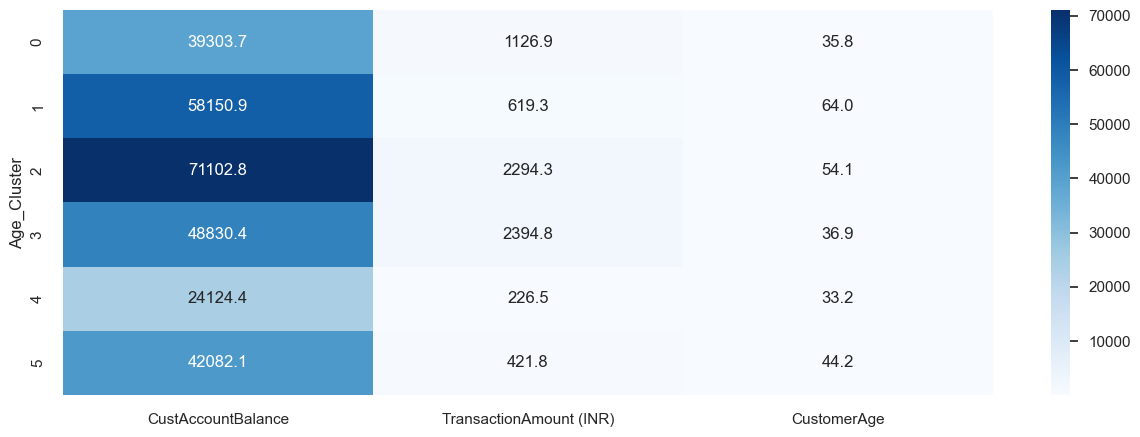

In [62]:
mean_df = df.groupby('Age_Cluster')['CustAccountBalance','TransactionAmount (INR)','CustomerAge'].mean()
fig = plt.figure(figsize = (15,5))
sns.heatmap(data = mean_df , cmap = 'Blues' , annot = True, fmt = ".1f" )

In [63]:
mean_df.head(6)

,CustAccountBalance,TransactionAmount (INR),CustomerAge
Age_Cluster,,,
0,39303.74,1126.91,35.84
1,58150.91,619.32,64.02
2,71102.82,2294.29,54.11
3,48830.38,2394.77,36.94
4,24124.39,226.48,33.18


In [64]:
df['color_age_km'] = df.Age_Cluster.map({i: colors_X[i] for i in range(6)})


,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,Age_Cluster,AgeGroup,color_age_km
892845,1,1524,84447.82,2567.50,39.00,3,36-45,green
444994,1,1325,12549.49,250.00,30.00,4,26-35,blue
614896,1,2437,33607.65,2567.50,33.00,3,26-35,green
457036,1,1443,38238.86,250.00,33.00,4,26-35,blue
997441,1,2801,9506.85,33.00,35.00,4,26-35,blue


__Conclusion__

- Cluster 4 consists of customers with average age "33+" their activity on transaction amount and account balance is typically lower, which makes this cluster a potential target for engagement and marketing strategies to increase their transaction involvement. 
- Cluster 2 consists of customers with average age of "54+", their bank balances are typically higher as is their transaction activity as compared to other clusters. 
- It is interesting to note that after the ages of 54, the average account balance and transcation activity lowers. This is reflected in the cluster 1 which represents the average age group of "64+".
- By applying tailored marketing campaigns, customer interaction and engagement can be improved and the bank can make better returns on the investments.